longshort_candidates_2023_06_08_00_00_00 already exists


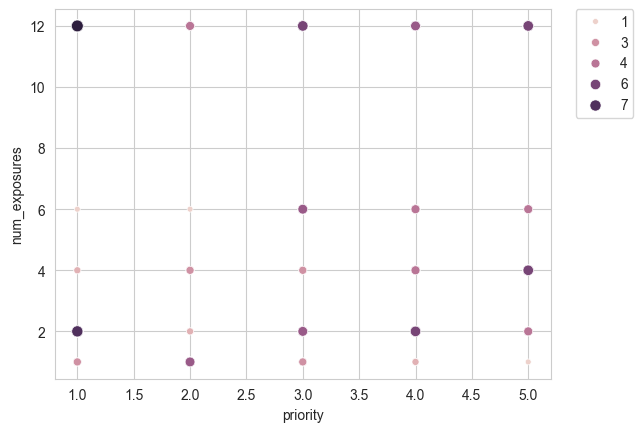

In [1]:
import random

import astropy.units as u
import pandas as pd
from astroplan import FixedTarget
from astroplan import ObservingBlock, AirmassConstraint, AtNightConstraint, Schedule, SequentialScheduler
from astroplan import PriorityScheduler
from astroplan.plots import plot_schedule_airmass
from astropy.coordinates import SkyCoord
from sqlalchemy import create_engine

from utils import obs_start, obs_end, observer
from utils import observing_date

engine = create_engine('sqlite:///astrosa/data/astrosa.sqlite')
conn = engine.connect()
date_string = observing_date.strftime("%Y_%m_%d_%H_%M_%S")

# if table exists, read it
# if not, create it
candidates_table_name = f"longshort_candidates_{date_string}"
try:
    candidates = pd.read_sql_table(candidates_table_name, con=conn)
    print(f"{candidates_table_name} already exists")
except ValueError:
    print(f"{candidates_table_name} not exists")
    candidates = pd.read_sql_table(f'candidate_{date_string}', con=conn)

    exposure_elapsed = [1, 2, 4, 6, 12]
    random.randint(0, 5)
    candidates['num_exposures'] = [exposure_elapsed[random.randint(0, 4)] for _ in range(len(candidates))]
    candidates['minutes_per_exposure'] = 5
    candidates['exposure_minutes'] = candidates['num_exposures'] * candidates['minutes_per_exposure']
    # save to db
    try:
        candidates.to_sql(candidates_table_name,
                          con=conn,
                          index=False)
    except ValueError:
        print(f"{candidates_table_name} already exists")

candidates_icrs = SkyCoord(ra=candidates.RA_ICRS_.to_numpy() * u.deg,
                           dec=candidates.DE_ICRS_.to_numpy() * u.deg,
                           frame='icrs')

from matplotlib import pyplot as plt
import seaborn as sns

# count the number of targets in the same priority-exposure time pair
candidates['count'] = candidates.groupby(['priority', 'num_exposures'])['priority'].transform('count')

# plot priority versus exposure time, the scatter size is the count of the target
sns.scatterplot(data=candidates, x='priority', y='num_exposures', size='count', hue='count')

# set legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [2]:

blocks = []
for star, name, p, (_, v) in zip(candidates_icrs,
                                 candidates.ID,
                                 candidates.priority,
                                 candidates.iterrows()):
    target = FixedTarget(coord=star, name=name)

    # b = ObservingBlock(target, v.num_exposures * u.min, priority=p)
    b = ObservingBlock.from_exposures(target, p, 5 * u.min, v.num_exposures)
    blocks.append(b)

    print(star, v.rise_time, p)

<SkyCoord (ICRS): (ra, dec) in deg
    (343.51905139, 19.59797639)> 2023-06-08 16:54:59.478047 5
<SkyCoord (ICRS): (ra, dec) in deg
    (307.53037806, 19.4301525)> 2023-06-08 14:32:06.644482 3
<SkyCoord (ICRS): (ra, dec) in deg
    (285.42016806, -5.73902333)> 2023-06-08 15:00:20.300353 5
<SkyCoord (ICRS): (ra, dec) in deg
    (8.12505278, 51.72825917)> 2023-06-08 16:38:15.986407 1
<SkyCoord (ICRS): (ra, dec) in deg
    (336.69375333, 21.86967861)> 2023-06-08 16:19:46.168407 4
<SkyCoord (ICRS): (ra, dec) in deg
    (332.16866889, 0.33807639)> 2023-06-08 17:30:18.634486 4
<SkyCoord (ICRS): (ra, dec) in deg
    (313.38883722, 31.62614639)> 2023-06-08 14:13:35.919225 5
<SkyCoord (ICRS): (ra, dec) in deg
    (348.62714944, 20.44226889)> 2023-06-08 17:12:22.921029 2
<SkyCoord (ICRS): (ra, dec) in deg
    (357.98283889, 40.74509694)> 2023-06-08 16:40:16.050692 4
<SkyCoord (ICRS): (ra, dec) in deg
    (284.69709, -5.63484361)> 2023-06-08 14:56:46.569064 5
<SkyCoord (ICRS): (ra, dec) in deg
  

In [3]:
from astrosa.assess import Transitioner

# create the list of constraints that all targets must satisfy
global_constraints = [AirmassConstraint(max=3, boolean_constraint=False),
                      AtNightConstraint.twilight_astronomical()]

slew_rate = 3 * u.deg / u.second  # 1.2M 最大转速是 6 deg/s
transitioner = Transitioner([6 * u.deg / u.second, 6 * u.deg / u.second],
                            [1 * u.deg / u.second ** 2, 1 * u.deg / u.second ** 2],
                            slew_rate,
                            {'filter': {('B', 'G'): 10 * u.second,
                                        ('G', 'R'): 10 * u.second,
                                        'default': 30 * u.second}})


In [4]:
priority_scheduler = PriorityScheduler(constraints=global_constraints,
                                       observer=observer,
                                       transitioner=transitioner)
schedule_prio = Schedule(obs_start, obs_end)
priority_scheduler(blocks, schedule_prio)

seq_scheduler = SequentialScheduler(constraints=global_constraints,
                                    observer=observer,
                                    transitioner=transitioner)

schedule_seq = Schedule(obs_start, obs_end)
seq_scheduler(blocks, schedule_seq)

Schedule containing 7 observing blocks between 2023-06-08 13:35:16.683 and 2023-06-08 17:32:01.974

Text(0.5, 1.0, 'Priority Scheduler')

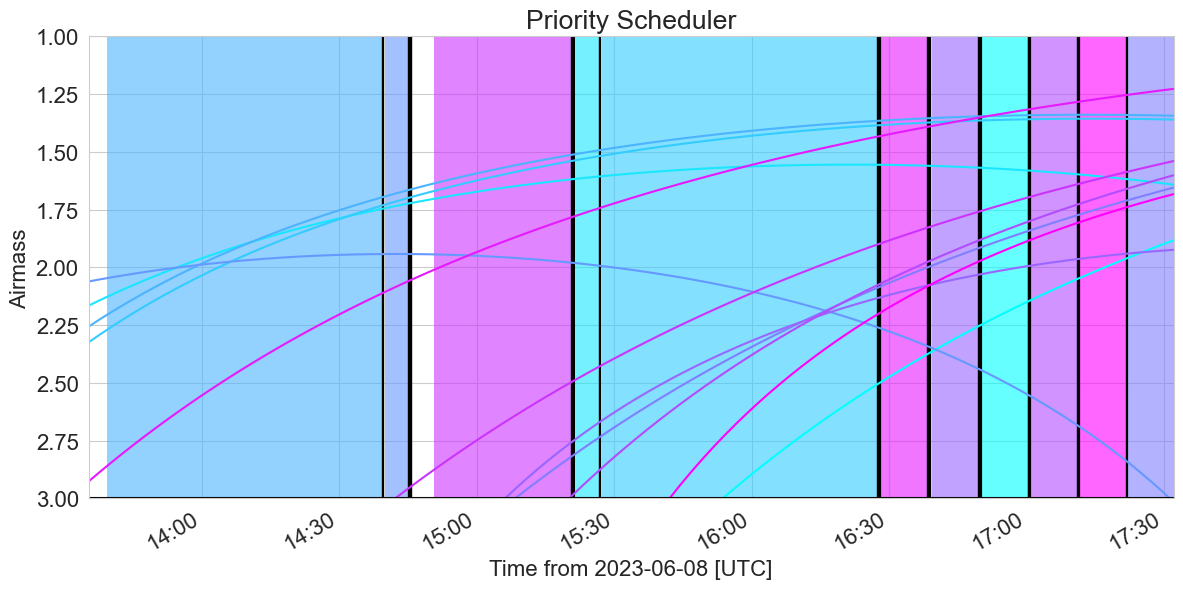

In [5]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule_prio)
plt.title('Priority Scheduler')

Text(0.5, 1.0, 'Sequential Scheduler')

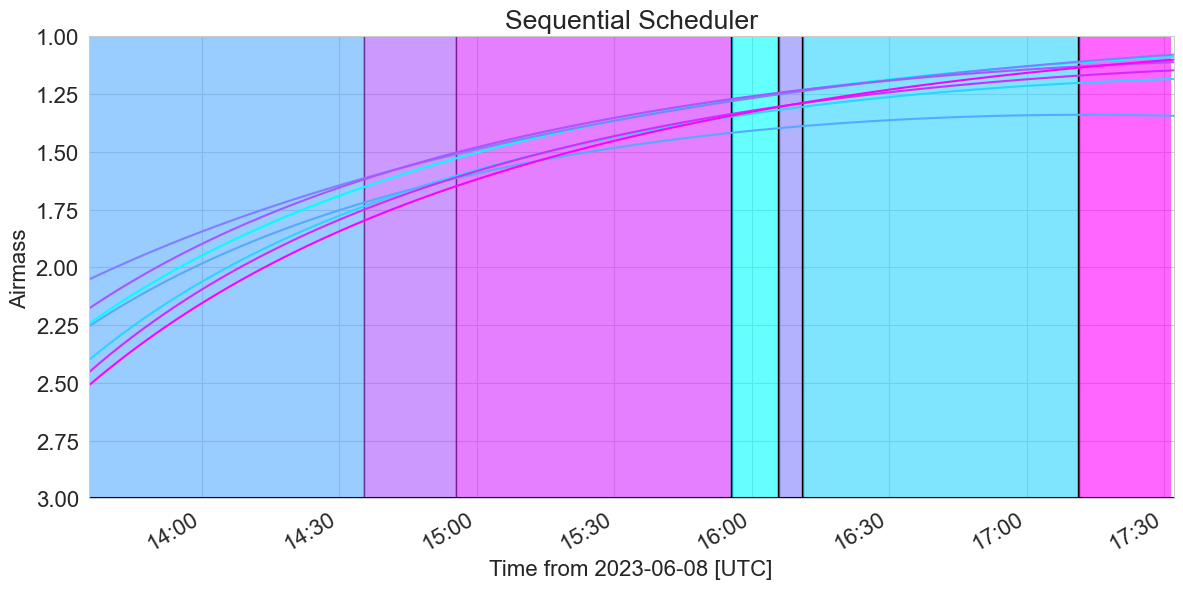

In [6]:
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule_seq)
plt.title('Sequential Scheduler')

In [7]:
from utils import schedule2df_ex

x = schedule2df_ex(schedule_seq)
x.to_sql(f"sequential_schedule_{date_string}_longshort", con=conn, if_exists='replace', index=False)

x = schedule2df_ex(schedule_prio)
x.to_sql(f"priority_schedule_{date_string}_longshort", con=conn, if_exists='replace', index=False)

11